 # ARIMA Model: Forecasting Number of Sales of E-Bikes in Germany

The following script shows an example how to forecast the number of sales of E-bikes in Germany using an ARIMA model. Of course no warranty is given for correctness an accuracy of the model and predictions. The input data originates from Statista https://de.statista.com/statistik/daten/studie/152721/umfrage/absatz-von-e-bikes-in-deutschland/ [1].

## 1. Import Packages 

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from pmdarima.arima import ARIMA
from pmdarima.arima import ndiffs
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## 2.Read, Prepare and Plot historic Data

As a first step data is prepared for the ARIMA model and plotted to get a first impression of data history. 

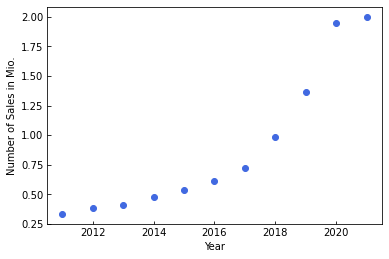

,Year,Number of Sales
0,2011,0.33
1,2012,0.38
2,2013,0.41
3,2014,0.48
4,2015,0.54
5,2016,0.61
6,2017,0.72
7,2018,0.98
8,2019,1.36
9,2020,1.95


In [2]:
df=pd.read_csv('Absatz_Ebike.csv', delimiter=';', header=None)
df.columns=['Year', 'Number of Sales']
df.iloc[:,1]=df.iloc[:,1]/1_000_000 

# Plot data
fig, ax=plt.subplots()
plt.rc('axes', labelsize=13)
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13) 
ax.plot(df.iloc[:,0],df.iloc[:,-1], 'o', color='royalblue')
ax.tick_params(which='major', axis='x', direction='in')
ax.tick_params(which='major', axis='y', direction='in')
plt.xlabel('Year')
plt.ylabel('Number of Sales in Mio.')
plt.show()
df

## Evaluate Model Parameters

A non-seasonal ARIMA model requires three input parameters (p,d,q). p is used as parameter for the autoregressive (AR) part of the model. It describes the dependence of subsequent observations on the number of previous observations. Parameter d represents the number of differentiations to achieve a stationarity, q is needed for the moving-average (MA) part of the time series and is a measure for how many previous prediction errors are included for the prediction of subsequent values. As a first step the stationarity is checked. Secondly, the autocorrelation function and the partial autocorrelation function is used to get an estimation for p and q parameters. As a final step the AIC is used to optimize the model.

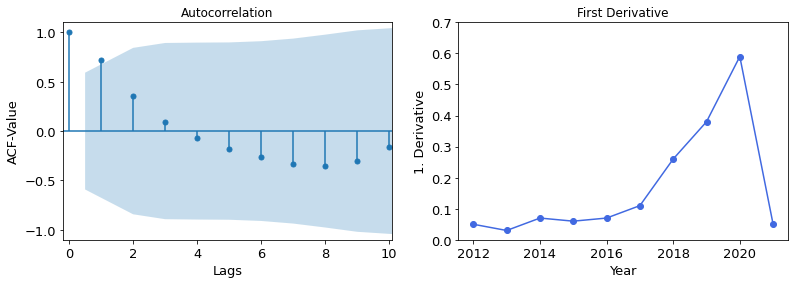

p-Value ADF: 0.9949267104025062 
p-Value ADF 1st-deriv.: 0.021236134631917376


In [3]:
# Define x and y vectors 
x_train=np.array(df.iloc[:,0])
y_train = np.array(df.iloc[:,-1])

# Plot autocorrelation and partial autocorrelation functions without differentiating
fig, ax = plt.subplots(1,2,figsize=(13,4))
plot_acf(y_train, alpha=0.05, ax=ax[0])
ax[0].set_xlabel('Lags')
ax[0].set_ylabel('ACF-Value')
ax[0].set_xlim([-0.2,10.1])
ax[0].set_ylim([-1.1,1.1])

ax[1].plot(x_train[1:], np.diff(y_train), 'o-', color='royalblue')
ax[1].set_ylim([0,0.7])
ax[1].set_title('First Derivative')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('1. Derivative')
plt.show()

# Ad-Fuller Test to check stationarity
adf_1=adfuller(y_train)
adf_2=adfuller(np.diff(y_train))
print('p-Value ADF:' ,adf_1[1], '\n''p-Value ADF 1st-deriv.:', adf_2[1])

At least there seems to be one differentiation required to reach stationarity. This is consitent with an almost linear decrease of the ACF values up to lag four. Obviously there is still a visible trend in data (right panel). Since also the ACF shows a non-linear shape from lag 5, d=1 is used as minimum value and d=2 as a maximum value for optimizing the ARIMA model via AIC. The Ad-Fuller test also suggests at least a linear trend since the p-value is below 0.05 after differentiating.

As a next step the p parameter is estimated. For this the autocorrelation function of the first derivative is used.

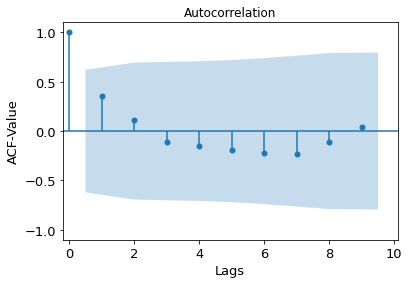

In [4]:
# Autocorrelation function of first derivative
plot_acf(np.diff(y_train), alpha=0.05)
plt.xlabel('Lags')
plt.ylabel('ACF-Value')
plt.xlim([-0.2,10.1])
plt.ylim([-1.1,1.1])
plt.show()

No lag is larger than the confidence intervall, thus the lower limit for the p value is p=0. For AIC optimization an upper limit of p=1 is used.

A similar procedure is used to estimate the q parameter. The partial autocorrelation function reveals useful information for an initial value. 

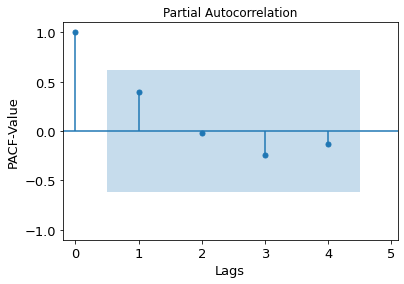

In [5]:
# PACF for q estimation
plot_pacf(np.diff(y_train), lags=4, alpha=0.05)
plt.xlabel('Lags')
plt.ylabel('PACF-Value')
plt.xlim([-0.2,5.1])
plt.ylim([-1.1,1.1])
plt.show()

No lag is larger than the confidence intervall, thus the lower limit for the q value is q=0. For AIC optimization an upper limit of q=1 is used.
As a last step for parameter evaluation the AIC is optimized using the auto_ARIMA function using the previously estimatet parameter intervalls.

## Model Prediction

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2.275, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1.631, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.616, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2.102, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.314, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.085 seconds


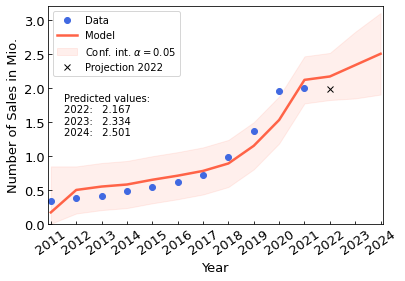

In [6]:
# Auto-ARIMA for parameter optimization
model=auto_arima(y_train, start_p=0, d=1,  start_q=0, max_p=3,  max_q=3, stationary=False, information_criterion='aic', alpha=0.05, trace=True, maxiter=100, suppress_warnings=False,  scoring='mse', intercept='auto')
model.fit(y_train)

# Prediction of next three values
prediction, confint = model.predict(n_periods=3, return_conf_int=True)
res=model.predict_in_sample(return_conf_int=True, alpha=0.05)
y_pred=res[0].tolist()+prediction.tolist()

# Preparing confidence intervall for plotting
res[1][0,1]=res[1][1,1] # estimate confidence interval of first value
res[1][0,0]=0 # estimate confidence interval of first value
upper=res[1][:,1].tolist()+confint[:,1].tolist() 
lower=res[1][:,0].tolist()+confint[:,0].tolist() 
x_predict=range(2011,2025)

# PLotting final result
fig, ax=plt.subplots()
ax.plot(df.iloc[:,0],df.iloc[:,-1], 'o', color='royalblue', linewidth=2.5, label='Data')
ax.plot(x_predict, y_pred, '-', color='tomato', linewidth=2.5, label='Model')
plt.fill_between(x_predict, lower, upper, alpha=0.1, color='tomato', label='Conf. int. $\\alpha=0.05$')
ax.set_xticks(range(2011,2025))
plt.plot(2022,1.98, 'x', color='k', label= 'Projection 2022')
plt.xticks(rotation=35)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=11) 
plt.rc('ytick', labelsize=11)
ax.tick_params(which='major', axis='x', direction='in')
ax.tick_params(which='major', axis='y', direction='in')
ax.set_xlim([2010.9, 2024.1])
ax.set_ylim([0,3.2])
plt.xlabel('Year')
plt.ylabel('Number of Sales in Mio.')
plt.legend()
plt.text(2011.5, 1.3, 'Predicted values:\n'+'2022:   '+str(round(prediction[0],3))+'\n'+'2023:   '+str(round(prediction[1],3))+'\n'+'2024:   '+str(round(prediction[2],3)))
plt.show()

The in-sample-prediction is in good agreement with the empirical data. Besides of one value, all data points are located within the confidence intervall. More interesting is of course the capability to predict future values. To get an impression of model quality, some online research allows to get a projection of 2022's number of sales. In [2] they assume the number of sales, based on actual sales, to be approximately 1 % below the value of 2021. This results in a number of sales of 1.98 Mio. Thus the model sligthly overestimates the value by approximately 9 %. Having a closer look to the current economic trends this behaviour is not surprising. The next section shows the analysis of a few market trends which can definetly not be adressed by this kind of forecast model.

## Model Plausibility and Conclusion

Finally the most important step of model evaluation is to check plausibility regarding the actual economic situation. World's economic is strongly influenced by multilateral and bilateral relations between countries, companies, politics, pandamics etc. It is interesting to observe that different sections correlate differently due to this trends. The automotive sector for example suffers already for approximately three years from these circumstances. The E-bike market seems to be a "winner" of the past incidents. Especially the pandemic pushed the sales numbers since people used their spare time for some biking activities. But this trend is definetly overlapped by the shortage of semiconductor chips since 2021 resulting in stagnation of sales numbers. This is obviously revealed by the above graph. For the model this means that there is a slight change in boundary conditions, effecting the stationarity of the data set. This evolution is still present. Also the Ukraine war and the resulting inflation seems to unsettle the potential costumers leading to decreasing sales numbers. Still the model gives a reasonable forecast but it definetly does not take the new circumstances into account.
To depict all these parameters in a forecast a different model based on multiple input features reflecting the world's situation would result in a more accurat prediction. My follow-up project tries to adress this challenges by using a CNN model combined with regression based on a neural network architecture.
To conclude: The current ARIMA model gives reasonable forecasts in predictable surroundings and also sligthly adresses the current circumstances. It defintely can be used for a rough trend analysis by taking the confidence intervall into account. Time will show how reliable the predicted values are.  


## Sources

[1] Statista, Absatz von E-Bikes in Deutschland von 2011 bis 2021, https://de.statista.com/statistik/daten/studie/152721/umfrage/absatz-von-e-bikes-in-deutschland/.

[2] Horst Schröder, IMTEST, E-Bike-Markt auch 2022 weiter auf hohem Niveau, https://www.imtest.de/252133/news/e-bike-markt-auch-2022-weiter-auf-hohem-niveau/.